<a href="https://colab.research.google.com/github/andandandand/practical-computer-vision/blob/main/notebooks/Image_Classification_with_FiftyOne_and_PyTorch_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Image Classification using FiftyOne and PyTorch

## Zero-shot Classification with CLIP and Supervised Learning with LeNet-5


### Who this Is for
This tutorial is designed for computer vision practitioners and data scientists who want to master image classification workflows using FiftyOne. Whether you're new to computer vision or experienced with other tools, you'll learn how to leverage FiftyOne's powerful capabilities for dataset curation, model evaluation, and visual analysis.

This tutorial is appropriate for any level of computer vision knowledge. By the end of this tutorial, you'll be able to quickly identify mislabeled samples, compare classification models, create meaningful embeddings, and seamlessly move between FiftyOne and PyTorch workflows.

### Assumed Knowledge
We assume familiarity with basic Python programming and fundamental machine learning concepts. Knowledge of PyTorch is helpful but not required,  we'll explain the key concepts as we go. This tutorial is recommended for beginners to intermediate practitioners in computer vision.

### Time to complete
90-120 minutes

### Required packages
FiftyOne, PyTorch, and several other packages are required. You can install them with:

```bash
pip install fiftyone==1.5.2 torch torchvision numpy
```




## Content Overview

### 1. MNIST Dataset Exploration with FiftyOne

Understand the MNIST dataset structure. Load the test split into FiftyOne. Compute and visualize metadata. Explore data distributions using aggregations and the FiftyOne App.

**Key concepts covered:**
*   Loading datasets from FiftyOne Dataset Zoo
*   Computing image metadata
*   Using FiftyOne aggregations for data statistics
*   Visualizing dataset distributions

### 2. Image Embeddings with CLIP

Generate image embeddings for the test dataset using a pre-trained CLIP model. Visualize these high dimensional vectors in 2D using PCA and UMAP to understand image similarity.

**Key concepts covered:**
*   Loading pre-trained models from FiftyOne Model Zoo
*   Computing image embeddings with CLIP
*   Assigning embeddings to dataset samples
*   Dimensionality reduction: PCA and UMAP
*   Visualizing embedding plots in FiftyOne

### 3. Dataset Analysis using CLIP Embeddings

Continue analysis of the CLIP embeddings on the test dataset. Explore dataset clustering concepts. Compute and examine sample uniqueness and representativeness based on CLIP embeddings.

**Key concepts covered:**
*   Introduction to clustering with embeddings
*   Creating a similarity index
*   Identifying outliers and representative samples

### 4. Zero-Shot Classification with CLIP

Perform image classification on the test dataset using CLIP without task specific training. Evaluate CLIP's performance using FiftyOne's tools.

**Key concepts covered:**
*   Zero-shot classification principles
*   Text prompts for classification
*   Applying a model to a FiftyOne dataset
*   Evaluating classification results including accuracy and confusion matrix

### 5. Supervised Classification: LeNet-5 with PyTorch

Build and train a LeNet-5 convolutional neural network from scratch using PyTorch. Prepare the MNIST training data. Implement the training loop and validation procedures.

**Key concepts covered:**
*   LeNet-5 architecture
*   Defining a subclass of PyTorch's `nn.Module`
*   Splitting FiftyOne data for training and validation
*   Creating custom PyTorch Datasets from FiftyOne views
*   Data normalization through mean and standard deviation computation
*   PyTorch DataLoaders
*   Defining loss functions and optimizers
*   Training loops and model checkpointing

### 6. LeNet-5 Model Evaluation on Test Data

Apply the trained LeNet-5 model to the MNIST test set. Store predictions in FiftyOne. Evaluate its performance. Analyze prediction characteristics, including hardness and mistakenness.

**Key concepts covered:**
*   Applying a PyTorch model to a FiftyOne dataset
*   Storing predictions, confidence, and logits
*   Evaluating classification performance
*   Analyzing prediction confidence distributions
*   Computing sample hardness and mistakenness

### 7. Analysis of LeNet-5 Learned Features using Training Data

Extract embeddings from the trained LeNet-5 model using the training data. Compute and visualize these embeddings. Analyze uniqueness and representativeness based on LeNet's learned features. Identify misclassifications within the training set.

**Key concepts covered:**
*   Extracting embeddings from intermediate PyTorch model layers
*   Storing custom model embeddings in FiftyOne
*   Visualizing custom embeddings with PCA and UMAP
*   Analyzing uniqueness and representativeness of training samples
*   Evaluating model performance on training data
*   Identifying false positives and false negatives in training data

### 8. Data Augmentation Concepts for MNIST

Understand effective data augmentation strategies for the MNIST dataset. Learn about geometric transformations and elastic deformations. Discuss augmentations to avoid. This section provides a conceptual discussion.

**Key concepts covered:**
*   Rationale for data augmentation
*   Geometric and elastic transformations suitable for MNIST
*   Best practices and pitfalls in augmentation

## Installation

In [ ]:
# Remove > /dev/null if you encounter errors during installation
!pip install fiftyone==1.5.2 > /dev/null

### FiftyOne Plug-ins

We'll also install FiftyOne plugins for model evaluation and data augmentation:






In [ ]:
# Plug-in to evaluate the performance of our classification models
!fiftyone plugins download \
    https://github.com/voxel51/fiftyone-plugins \
    --plugin-names @voxel51/evaluation


Skipping existing plugin '@voxel51/evaluation'


In [ ]:
# Plug-in for image augmentations
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin


Copying plugin '@jacobmarks/albumentations_augmentation' to '/root/fiftyone/__plugins__/@jacobmarks/albumentations_augmentation'


## Imports

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
import torch
import torchvision.transforms.v2 as transforms
from PIL import Image
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as Fun
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm
from torch.optim import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import gc

## The MNIST dataset

![](https://github.com/andandandand/practical-computer-vision/blob/main/images/mnist_clean.png?raw=true)

The Modified National Institute of Standards and Technology (MNIST) dataset stands as one of the most influential benchmarks in computer vision and machine learning history. Created by Yann LeCun and colleagues in 1998, MNIST transformed a collection of handwritten digits from American Census Bureau employees and high school students into a standardized machine learning challenge that has shaped decades of research.



**Dataset Structure and Characteristics**

The MNIST dataset contains 60,000 training images and 10,000 testing images of handwritten digits (0-9). These are grayscale images of size 28x28 pixels, with each pixel value ranging from 0 (black) to 255 (white). The images have been size-normalized and centered, making them ideal for learning fundamental computer vision concepts without the complexity of dealing with varying scales, rotations, or backgrounds found in natural images. You can inspect the samples on the test portion of the dataset through [try.fiftyone.ai](https://try.fiftyone.ai/datasets/mnist/samples).

**Historical Significance and Impact**

MNIST earned its status as the "Hello World" of computer vision for several reasons. First, it provided the research community with a common benchmark that was computationally tractable, even early personal computers could train models on MNIST in reasonable time. Second, its simplicity allowed researchers to focus on algorithmic innovations rather than data preprocessing challenges. Landmark achievements in deep learning, from early multilayer perceptrons to convolutional architectures like LeNet-5, were first demonstrated and validated on MNIST.

The dataset served as a proving ground for fundamental concepts of modern computer vision: convolutional neural networks, regularization techniques, and optimization algorithms were all tested on these handwritten digits. Many techniques that seem obvious today, like data augmentation, dropout, and batch normalization, were first explored and validated using MNIST as a testbed.

**Why MNIST Remains Relevant**

While critics sometimes dismiss MNIST as "too easy" for modern standards, it continues to serve crucial educational and research purposes. For newcomers to computer vision, MNIST provides an ideal environment to understand core concepts without overwhelming complexity. The dataset is small enough to experiment with quickly, yet rich enough to demonstrate important phenomena like overfitting, the importance of data augmentation, and the impact of architectural choices.

Moreover, MNIST's apparent simplicity can be deceptive. Achieving state-of-the-art performance >99.7% accuracy requires sophisticated techniques and careful attention to detail, making it an interesting benchmark for testing new methodologies.


## MNIST in the Modern Era

Today, MNIST serves as an excellent starting point for understanding how modern techniques like embeddings, zero-shot classification, and transfer learning work. While a model trained specifically on MNIST might achieve 99%+ accuracy, applying a general-purpose vision model like CLIP without any MNIST-specific training provides insights into how well these models generalize and what they've learned about visual patterns from their massive training datasets.

This makes MNIST perfect for comparing traditional supervised learning approaches with modern pre-trained models, helping us understand the trade-offs between task-specific optimization and general-purpose visual understanding.


## CLIP

**CLIP (Contrastive Language-Image Pre-training)** is a vision-language model developed by OpenAI that learns to understand the relationship between images and text descriptions. Traditional computer vision models are trained on fixed sets of image categories, but CLIP was trained on 400 million image-text pairs from the internet, learning to match images with their captions. This training enables CLIP to perform "zero-shot" classification: the ability to classify images into categories it has not seen during training by comparing the image representation with text descriptions of potential classes. The model works by encoding both images and text into the same high-dimensional embedding space, where similar concepts cluster together, allowing it to determine which text description best matches a given image through similarity comparison.

![](https://github.com/andandandand/images-for-colab-notebooks/blob/main/clip%20contrastive%20pre-training.png?raw=true)

### CLIP vs MNIST

In [OpenAI's 2021 CLIP paper](https://arxiv.org/abs/2103.00020), the comparison with MNIST revealed fascinating insights about zero-shot learning capabilities. While supervised models trained specifically on MNIST achieve near-perfect accuracy (>99.7%), OpenAI's best performing variant of CLIP (trained on about 400 million image-text pairs) achieved only 88% accuracy on these handwritten digits. This is interesting considering the model was not trained explicitly trained on any variant of this dataset. This comparison highlighted a shift in modern computer vision from specialized models that excel at narrow tasks to general models that perform reasonably well across diverse domains. The 11+ percentage point gap between supervised and zero-shot approaches on MNIST demonstrates both the power and limitations of general-purpose vision-language models, making MNIST an excellent case study for understanding the trade-offs between specialized optimization and general-purpose learning, particularly valuable for exploring modern approaches like few-shot learning, prompt engineering, and transfer learning strategies.

Note that the variant of CLIP that we use in our experiments of this notebook, `"clip-vit-base32-torch"` (a Vit-B/32 model) is *not* the top performing variant of CLIP that is showcased on the original OpenAI paper. That would be "ViT-L/14@336px", a bigger vision transformer model. The Vit-B/32 base models remain interesting and widely used due to their lower number of parameters.


**Known Issues and Research Opportunities**

The original dataset contains several images where the ground truth labeling is ambiguous or questionable. The academic community has identified [several of these ambiguous samples](https://arxiv.org/abs/1912.05283). These labeling inconsistencies, while representing less than 0.1% of the dataset, provide opportunities to explore data quality assessment techniques.

Finding and analyzing these edge cases teaches valuable lessons about real-world data challenges. In production systems, you'll inevitably encounter ambiguous samples, annotation errors, and edge cases. MNIST's imperfections make it an excellent sandbox for developing robust approaches to handle these issues. Let's see if we can find them using FiftyOne's powerful analysis capabilities!

## Zero-shot Classification vs "Traditional" Supervised Training

**Zero-shot classification** leverages pre-trained models like CLIP that have learned rich visual representations from massive datasets, allowing them to classify images into "interpolated" categories they've not explicitly seen during training. These models understand the semantic relationship between images and text descriptions, enabling classification through natural language prompts like "a photo of the digit 3" without requiring any task-specific training data. In contrast, **traditional supervised training** requires labeled examples for each class you want to predict. You must provide the model with many of images of each digit along with their correct labels, then train the network to learn the mapping from pixel patterns to class labels through backpropagation. While supervised training often achieves higher accuracy on specific datasets and allows for domain-specific optimization, zero-shot approaches offer remarkable flexibility and can instantly work on new classification tasks without additional training time or computational resources.

## Where CLIP Does Really Well: Matching Scene Descriptions to Images Similar to its Training Corpus

![](https://github.com/andandandand/practical-computer-vision/blob/main/images/zero-shot-clip.png?raw=true)

## Where CLIP Fails: "Specialized" Domains

![](https://github.com/andandandand/practical-computer-vision/blob/main/images/clip_limitations.png?raw=true)

### Loading the MNIST Dataset from FiftyOne's Dataset Zoo

A FiftyOne dataset wraps together the annotations and image data into a unified, queryable structure that makes computer vision workflows seamless. Unlike traditional approaches where you might manage separate files for images and labels, FiftyOne treats each sample as a rich object containing the image itself, ground truth labels, metadata, and any predictions or embeddings you add later. This design enables powerful operations like filtering by class imbalance, visualizing prediction confidence, or finding samples with specific characteristics, all through a consistent API.

Loading MNIST from [FiftyOne's Dataset Zoo](https://docs.voxel51.com/dataset_zoo/index.html) is straightforward:


In [ ]:
# We will load the test split from the dataset first
test_dataset = foz.load_zoo_dataset("mnist", split='test')
test_dataset

Split 'test' already downloaded


INFO:fiftyone.zoo.datasets:Split 'test' already downloaded


Loading 'mnist' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'mnist' split 'test'


 100% |█████████████| 10000/10000 [6.0s elapsed, 0s remaining, 1.9K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [6.0s elapsed, 0s remaining, 1.9K samples/s]      


Dataset 'mnist-test' created


INFO:fiftyone.zoo.datasets:Dataset 'mnist-test' created


Name:        mnist-test
Media type:  image
Num samples: 10000
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)

We launch the FiftyOne app to visualize the test set.

In [ ]:
session = fo.launch_app(test_dataset, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


With `compute_metadata()` we add the size in bytes, the image file type, the width and height of the image, and the number of channels to our dataset.

In [ ]:
test_dataset.compute_metadata()

Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |█████████████| 10000/10000 [3.9s elapsed, 0s remaining, 2.8K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [3.9s elapsed, 0s remaining, 2.8K samples/s]      


We can do [aggregations](https://docs.voxel51.com/user_guide/using_aggregations.html) on the dataset to explore the dataset.



We can use the [bounds](https://docs.voxel51.com/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.bounds) aggregation to compute the [min, max] range of a numeric field of a dataset. And [mean()](https://docs.voxel51.com/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.bounds) and [std()](https://docs.voxel51.com/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.std) to compute the mean and standard deviation of it.



In [ ]:
test_dataset.bounds("metadata.size_bytes")

(483, 1033)

In [ ]:
test_dataset.mean("metadata.size_bytes"), test_dataset.std("metadata.size_bytes")

(768.6065, 84.01331833554713)

Try filtering by label and visualizing the metadata of the MNIST images through the FiftyOne app.

![](https://github.com/andandandand/practical-computer-vision/blob/main/images/filtering_by_label_mnist_w_metadata.png?raw=true)

In [ ]:
print(session.url)

https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


We can also visualize the distributions of `metadata.size_bytes` and `ground_truth.label`. Both of these are relevant when we decide the batch size on which to run our models and to evaluate the balance of classes in our dataset.

![](https://github.com/andandandand/practical-computer-vision/blob/main/images/distribtution_size_bytes.png?raw=true)

For this try clicking on the `+` symbol next to samples, select `Histograms` and then `metadata.size_bytes` and `ground_truth.label` from the dropdown menu. The `Split horizontally button` will allow you to see the panel alongside the image data.


![](https://github.com/andandandand/practical-computer-vision/blob/main/images/ground_truh_distribution_mnist.png?raw=true)

## Creating Image Embeddings with CLIP

**Image embeddings** are high-dimensional vector representations that capture the semantic and aesthetic content of images in a vector format that machine learning models can understand and compare.

Think of embeddings as a way to translate visual concepts into vectors where similar images will correspond to similar embedding vectors, while visually or semantically different images will have more distant vectors in a high-dimensional space.

OpenAI's CLIP model creates particularly powerful embeddings because it was trained to understand the relationship between images and their matching text descriptions, enabling it to capture rich semantic meaning. In FiftyOne, creating embeddings with CLIP is straightforward:

1. We obtain the model through [`foz.load_zoo_model(""clip-vit-base32-torch"")`](https://docs.voxel51.com/model_zoo/models.html#clip-vit-base32-torch) and pass it to the GPU (if we have it available).
2. We use the [`compute_embeddings()`](https://docs.voxel51.com/api/fiftyone.brain.internal.core.elasticsearch.html#fiftyone.brain.internal.core.elasticsearch.ElasticsearchSimilarityIndex.compute_embeddings) method:




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = foz.load_zoo_model("clip-vit-base32-torch",
                                device=device)
print(f"The model is loaded on {clip_model._device}")

The model is loaded on cuda


In [ ]:
# Calculate the total number of parameters in the model
total_params = sum(p.numel() for p in clip_model._model.parameters())

print(f"The CLIP model has {total_params:,} parameters.")

The CLIP model has 151,277,313 parameters.


This will take about 3 min on a Google Colab instance with GPU enabled

In [ ]:
clip_embeddings = test_dataset.compute_embeddings(model=clip_model,
                                        batch_size=512,
                                        num_workers=2)

 100% |█████████████| 10000/10000 [32.1s elapsed, 0s remaining, 321.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [32.1s elapsed, 0s remaining, 321.3 samples/s]      


In [ ]:
# The embeddings are a NumPy array.
# Each embedding is a 512-dimensional vector.
type(clip_embeddings), clip_embeddings.shape

(numpy.ndarray, (10000, 512))

In [ ]:
for index, sample in enumerate(test_dataset):
    sample["clip_embeddings"] = clip_embeddings[index]
    sample.save()

In [ ]:
# We see that the first sample now has the field 'embeddings' attached to it
test_dataset.first().clip_embeddings.shape

(512,)

### Creating a 2D Projection of the Embeddings for Visualization

In [ ]:
pca_visualization = fob.compute_visualization(test_dataset,
                                              method="pca",
                                              embeddings="clip_embeddings",
                                              num_dims=2,
                                              brain_key="pca_visualization_clip_embeds")

Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


In [ ]:
umap_visualization = fob.compute_visualization(test_dataset,
                                              method="umap",
                                              embeddings="clip_embeddings",
                                              num_dims=2,
                                              brain_key="umap_visualization_clip_embeds")

Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Tue Jun 10 19:29:01 2025 Construct fuzzy simplicial set
Tue Jun 10 19:29:01 2025 Finding Nearest Neighbors
Tue Jun 10 19:29:01 2025 Building RP forest with 10 trees
Tue Jun 10 19:29:06 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Tue Jun 10 19:29:19 2025 Finished Nearest Neighbor Search
Tue Jun 10 19:29:21 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jun 10 19:29:29 2025 Finished embedding


In [ ]:
session.refresh()
print(session.url)

https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


![](https://github.com/andandandand/practical-computer-vision/blob/main/images/image_embeddings_zero_cluster.gif?raw=true)

In [ ]:
# Note that uniqueness and representativeness fields have been added to the dataset
test_dataset

Name:        mnist-test
Media type:  image
Num samples: 10000
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    clip_embeddings:  fiftyone.core.fields.VectorField

Let's use the FiftyOne app to explore the most unique and representative samples in the dataset.

In [ ]:
session.refresh()
print(session.url)

https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


## Clustering through Embeddings


**Clustering** transforms the high-dimensional embedding space into groups of similar images, helping us discover hidden patterns and structure in our dataset. Rather than manually browsing through thousands of images, clustering algorithms like K-means, HDBSCAN, or Gaussian Mixture Models automatically identify samples that share visual or semantic characteristics. This is particularly powerful when combined with CLIP embeddings, as the clusters often correspond to semantic concepts like "outdoor scenes," "close-up portraits," or "nighttime images." FiftyOne provides a dedicated clustering plugin that makes this analysis seamless. Install it with:




In [ ]:
!fiftyone plugins download https://github.com/jacobmarks/clustering-plugin


Skipping existing plugin '@jacobmarks/clustering'


Once installed, you can access clustering functionality directly from the FiftyOne App by pressing the backtick key (`) and typing `compute_clusters`. The plugin offers multiple clustering algorithms and customizable parameters. This workflow is valuable for understanding the groupings within your data produced by the embedding model. Learn more about clustering workflows and advanced techniques in the [FiftyOne clustering tutorial](https://docs.voxel51.com/tutorials/clustering.html).


In [ ]:
session.refresh()
print(session.url)

https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


## Zero-shot Classification

Now that we understand how CLIP creates meaningful embeddings, we can leverage these representations for **zero-shot classification** - the ability to classify images into categories without any task-specific training. CLIP's vision-language training enables it to understand the semantic relationship between images and text descriptions, allowing us to classify MNIST digits simply by providing natural language descriptions of each class.

The key insight is that CLIP learns to map both images and text into the same embedding space, where semantically similar concepts cluster together. By computing the similarity between an image's embedding and text embeddings for each class description, we can determine which category best matches the input image. This approach is remarkably flexible, we can change our classification categories simply by modifying the text prompts, without retraining the models.

For MNIST digit classification, we'll use descriptive text prompts combined with the written names of each digit.


In [ ]:
# We obtain the distinct labels of the dataset
dataset_classes = sorted(test_dataset.distinct("ground_truth.label"))
dataset_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## The Effect of the Text Prompt

With CLIP, the `text_prompt` parameter can have a significant effect on the accuracy of the model, as it affects the text embedding for the label.

## Experiment

Try modifying the `text_prompt` field with:

* "The handwritten digit "
* "A grayscale image of the number "
* "A pixel illustration of the digit "
* "A low resolution image of the number"
* "An MNIST digit "

And observe the effect on the accuracy, precision and recall on our classification report.

In [ ]:
clip_model = foz.load_zoo_model(
    "clip-vit-base32-torch",
    text_prompt="A photo of ",
    classes=dataset_classes,
    device=device
)

In [ ]:
clip_model.preprocess

True

In [ ]:
clip_model._transforms

Compose(
    Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)

The `store_logits=True` parameter is important as it preserves the model's confidence scores for each prediction, enabling us to analyze prediction uncertainty and identify samples where the model was unsure. After applying the model, we can compute comprehensive evaluation metrics and visualize the results using FiftyOne's evaluation framework:

In [ ]:
test_dataset.apply_model(
    model=clip_model,
    label_field="clip_zero_shot_classification",
    # We need to store the logits to compute the "mistakenness" value
    store_logits=True,
    # This is how many samples we will show to the model at once
    batch_size=256,
    progress_bar=True,
     # Use more running threads if you have multiple cpus
    num_workers=os.cpu_count()
)

 100% |█████████████| 10000/10000 [37.3s elapsed, 0s remaining, 277.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [37.3s elapsed, 0s remaining, 277.3 samples/s]      


In [ ]:
session.refresh()
print(session.url)

https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


## Evaluating CLIP's Classification Performance

With our zero-shot CLIP predictions generated, we need to evaluate how well the model performs compared to the ground truth labels. FiftyOne provides powerful evaluation capabilities that go beyond simple accuracy metrics, allowing us to understand where and why our model succeeds or fails.

[FiftyOne's Model Evaluation Panel](https://docs.voxel51.com/user_guide/app.html#model-evaluation-panel-sub-new ) provides interactive confusion matrices, per-class metrics, and the ability to drill down into specific failure modes. This visual analysis helps identify systematic errors, class imbalances, and edge cases that pure numerical metrics might miss, enabling targeted improvements to your classification pipeline.




In [ ]:
evaluation_results = test_dataset.evaluate_classifications(
    "clip_zero_shot_classification",
    gt_field="ground_truth",
    eval_key="clip_zero_shot_eval")

session.refresh()
print(session.url)

https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


In [ ]:
evaluation_results.print_report(classes=dataset_classes, digits=3)

              precision    recall  f1-score   support

    0 - zero      0.256     0.999     0.408       980
     1 - one      0.145     0.033     0.053      1135
     2 - two      1.000     0.016     0.031      1032
   3 - three      0.901     0.386     0.541      1010
    4 - four      0.513     0.177     0.263       982
    5 - five      0.600     0.161     0.254       892
     6 - six      0.076     0.255     0.117       958
   7 - seven      0.613     0.635     0.624      1028
   8 - eight      0.178     0.115     0.140       974
    9 - nine      0.000     0.000     0.000      1009

    accuracy                          0.275     10000
   macro avg      0.428     0.278     0.243     10000
weighted avg      0.427     0.275     0.241     10000



## Evaluate the Classes where the Model is Performing Worst

In [ ]:
nines_view = test_dataset.filter_labels("ground_truth",
                                        F("$ground_truth.label") == "9 - nine"
                                       )

In [ ]:
session = fo.launch_app(nines_view, auto=False)
print(session.url)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


In [ ]:
## clear the clip_model from GPU memory
# Delete the model variable
del clip_model

# Run Python's garbage collector
gc.collect()

# Empty the CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("CUDA device memory from clip_model should be cleared.")

CUDA device memory from clip_model should be cleared.


## Creating a Custom Convolutional Neural Networks in PyTorch (Two Versions of LeNet-5)


While zero-shot classification with CLIP demonstrates the power of modern pre-trained models, understanding how to build and train convolutional neural networks from scratch remains fundamental to computer vision. **LeNet-5**, proposed by Yann LeCun in 1998, represents one of the earliest and most influential CNN architectures. Despite its age, LeNet-5 perfectly illustrates core CNN concepts including convolutional layers, pooling operations, and the transition from feature extraction to classification.

LeNet-5's architecture is elegantly simple yet effective: it uses alternating convolutional and pooling layers to extract hierarchical features, followed by fully connected layers for classification. The network learns low-level features like edges and curves in early layers, then combines these into higher-level digit patterns in deeper layers. This hierarchical feature learning principle underlies virtually all modern CNN architectures.

For MNIST digit classification, LeNet-5 provides an excellent baseline to compare against CLIP's zero-shot performance. While CLIP leverages massive-scale pre-training and vision-language understanding, LeNet-5 demonstrates what's possible with task-specific supervised learning on a much smaller scale. Building this model from scratch in PyTorch teaches essential concepts about gradient-based optimization, backpropagation, and the relationship between network architecture and learning capacity.



Here is [a great animation](https://youtu.be/UxIS_PoVoz8?si=3ibZms7Hk1oSj55k) showcasing the architecture.



In [ ]:
class ClassicLeNet5(nn.Module):
    """
    LeNet-5 CNN architecture for MNIST digit classification.

    Original paper: "Gradient-Based Learning Applied to Document Recognition"
    by LeCun et al. (1998)

    Architecture (maintains original design with padding):
    Input (28x28) -> Pad to (32x32) -> C1 (6@28x28) -> S2 (6@14x14) ->
    C3 (16@10x10) -> S4 (16@5x5) -> C5 (120@1x1) -> F6 (84) -> Output (10)
    """

    def __init__(self, num_classes=10):
        super(ClassicLeNet5, self).__init__()

        # Feature extraction layers
        # C1: Convolutional layer - 6 feature maps, 5x5 kernels
        # Add padding=2 to convert 28x28 input to 32x32, maintaining original design
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)

        # S2: Subsampling layer (average pooling) - 2x2 with stride 2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: Convolutional layer - 16 feature maps, 5x5 kernels
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)

        # S4: Subsampling layer (average pooling) - 2x2 with stride 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: Convolutional layer - 120 feature maps, 5x5 kernels (original design)
        # This reduces the 5x5 feature maps to 1x1
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)

        # Classification layers
        # F6: Fully connected layer with 84 units
        self.fc1 = nn.Linear(120, 84)

        # Output layer: 10 classes for digits 0-9
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        # C1: Convolution + activation (padding converts 28x28 to 32x32, then conv to 28x28)
        # Input: (batch, 1, 28, 28) -> Pad to (32, 32) -> Conv to (batch, 6, 28, 28)
        x = torch.tanh(self.conv1(x))

        # S2: Average pooling
        # Input: (batch, 6, 28, 28) -> Output: (batch, 6, 14, 14)
        x = self.pool1(x)

        # C3: Convolution + activation
        # Input: (batch, 6, 14, 14) -> Output: (batch, 16, 10, 10)
        x = torch.tanh(self.conv2(x))

        # S4: Average pooling
        # Input: (batch, 16, 10, 10) -> Output: (batch, 16, 5, 5)
        x = self.pool2(x)

        # C5: Convolution + activation (original 5x5 kernel design)
        # Input: (batch, 16, 5, 5) -> Output: (batch, 120, 1, 1)
        x = torch.tanh(self.conv3(x))

        # Flatten for fully connected layers
        # Input: (batch, 120, 1, 1) -> Output: (batch, 120)
        x = x.view(x.size(0), -1)

        # F6: Fully connected + activation
        # Input: (batch, 120) -> Output: (batch, 84)
        x = torch.tanh(self.fc1(x))

        # Output layer (no activation - raw logits)
        # Input: (batch, 84) -> Output: (batch, 10)
        x = self.fc2(x)

        return x

Below is an alternative and more modern implementation. Here the activation functions have been switched from tanh to ReLU and Max Pooling is used instead of Average Pooling. Feel free to choose either!

Unlike the CLIP model, that has been pretrained, these networks are trained from scratch. We will use train portion of the MNIST dataset to do this.

In [ ]:
# Alternative modern version with ReLU and MaxPooling
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    Often performs better on MNIST than the original version.
    """

    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(Fun.relu(self.conv1(x)))
        x = self.pool(Fun.relu(self.conv2(x)))
        x = Fun.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = Fun.relu(self.fc1(x))
        x = self.dropout(x)  # Add dropout for regularization
        x = self.fc2(x)

        return x


## Obtain the Training Dataset

In [ ]:
# We use the training split to train our LeNet model
train_val_dataset = foz.load_zoo_dataset("mnist",
                                         split='train',
                                         dataset_name="mnist-train-val")
train_val_dataset.compute_metadata()

Split 'train' already downloaded


INFO:fiftyone.zoo.datasets:Split 'train' already downloaded


Loading 'mnist' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'mnist' split 'train'


 100% |█████████████| 60000/60000 [34.5s elapsed, 0s remaining, 1.9K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [34.5s elapsed, 0s remaining, 1.9K samples/s]      


Dataset 'mnist-train-val' created


INFO:fiftyone.zoo.datasets:Dataset 'mnist-train-val' created


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |█████████████| 60000/60000 [24.2s elapsed, 0s remaining, 2.8K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [24.2s elapsed, 0s remaining, 2.8K samples/s]      


## Splitting into Train and Validation

The **validation set** serves as an unbiased evaluation mechanism during model development, acting as a proxy for real-world performance before touching the final test set. While the training set teaches the model to recognize patterns in handwritten digits, the validation set reveals whether the model has truly learned generalizable features or simply memorized the training data, a phenomenon known as overfitting.

During training, we monitor both training and validation metrics simultaneously. **Training accuracy** typically increases steadily as the model learns, but **validation accuracy** tells the real story. If validation performance plateaus or begins declining while training accuracy continues improving, the model is overfitting and memorizing training-specific details rather than learning robust digit recognition patterns. This signals when to stop training, adjust hyperparameters, or modify the architecture.

The validation set also enables **hyperparameter tuning** without contaminating our final evaluation. We can experiment with different learning rates, batch sizes, regularization techniques, or architectural modifications, using validation performance to guide these decisions. Each configuration gets evaluated on the same held-out validation data, ensuring fair comparisons.

**Important: the test set remains completely untouched** throughout the development process. Only after we've selected our final model configuration based on validation performance do we evaluate on the test set once, giving us an honest estimate of how the model will perform on truly unseen data. This three-way split (train/validation/test) is fundamental to responsible machine learning development and prevents the subtle "data leakage" that can make models appear better than they actually are.



In [ ]:
# This will take a couple of minutes (60k samples).
# The images come with the 'train' tag and this must be deleted
# at the sample level.
for sample in tqdm(train_val_dataset, desc="Clearing tags"):
    sample.tags = []
    sample.save()

Clearing tags: 100%|██████████| 60000/60000 [01:09<00:00, 861.24it/s]


In [ ]:
## Correct Train/Validation Split for MNIST Training Dataset

# Create random 85%/15% split using tags
four.random_split(train_val_dataset,
                  {"train": 0.85, "validation": 0.15},
                  # The seed makes the split reproducible
                  seed=51)

# Verify the split by counting tags
tag_counts = train_val_dataset.count_sample_tags()
print("Tag counts after split:")
print(tag_counts)

# Create views for training and validation sets
train_view = train_val_dataset.match_tags("train")
val_view = train_val_dataset.match_tags("validation")

# Verify no overlap between train and validation
train_ids = set(train_view.values("id"))
val_ids = set(val_view.values("id"))
overlap = train_ids.intersection(val_ids)

Tag counts after split:
{'validation': 9000, 'train': 51000}


## Moving the FiftyOne Data Splits to torch Datasets







In [ ]:
# Custom PyTorch Dataset class for MNIST training data
class FiftyOneImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_view,
                 image_transforms=None,
                 label_map=None,
                 gt_field="ground_truth"):
        self.fiftyone_view = fiftyone_view
        self.image_paths = self.fiftyone_view.values("filepath")
        self.str_labels = self.fiftyone_view.values(f"{gt_field}.label")
        self.image_transforms = image_transforms

        if label_map is None:
            self.label_map = {str(i): i for i in range(10)}  # "0"->0, "1"->1, etc.
        else:
            self.label_map = label_map

        print(f"FiftyOneImageDataset initialized with {len(self.image_paths)} samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('L')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.randn(1, 28, 28), torch.tensor(-1, dtype=torch.long)

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str, -1)
        if label_idx == -1:
            print(f"Warning: Label '{label_str}' not in label_map for image {image_path}")

        return image, torch.tensor(label_idx, dtype=torch.long)

## Computing the Mean and Standard Deviation

Before training neural networks, we compute the **mean and standard deviation** of our input data to apply **standard scaling** (also called normalization or standardization).


**Standard Scaling Formula:**

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ = standardized value
- $x$ = original pixel value
- $\mu$ = mean of all pixel values in the dataset
- $\sigma$ = standard deviation of all pixel values in the dataset

In PyTorch, this is implemented with torch.`transforms.Normalize((mean_intensity), (std_intensity))`

This preprocessing step transforms our pixel values to have zero mean and unit variance, which provides several critical benefits:

**Why Standard Scaling Matters:**

**Gradient Optimization**: Neural networks learn through gradient descent, which works best when input features are on similar scales. Without scaling, features with larger magnitudes (like raw pixel values 0-255) can dominate the gradient updates, leading to slower convergence and unstable training.

**Weight Initialization Compatibility**: Modern weight initialization schemes (Xavier, He initialization) assume inputs are roughly centered around zero with unit variance. Standard scaling ensures our data matches these assumptions, preventing vanishing or exploding gradients during early training.

**Activation Function Efficiency**: Many activation functions (tanh, sigmoid) work optimally when inputs are centered around zero. Scaled inputs help neurons operate in the most responsive regions of these functions rather than saturating in flat regions.

**Learning Rate Stability**: With standardized inputs, we can use higher learning rates without instability, as the optimization landscape becomes more uniform across different dimensions.

For MNIST images, we transform raw pixel values from the range [0, 255] to approximately [-1, 1] with mean ≈ 0, creating a more favorable training environment that typically results in faster convergence and better final performance.


In [ ]:
def compute_stats_fiftyone(fiftyone_view):
    """
    Compute stats directly from FiftyOne using aggregations.
    Requires images to be loaded as arrays.
    """

    print("Computing image intensity statistics from FiftyOne view...")

    # Get all image filepaths
    filepaths = fiftyone_view.values("filepath")

    # Load all pixel values
    all_pixels = []

    for filepath in tqdm(filepaths):

        try:
            # Load image as grayscale array
            image = Image.open(filepath).convert('L')
            # Scale values to the range [0, 1]
            pixels = np.array(image, dtype=np.float32) / 255.0
            all_pixels.append(pixels.flatten())
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue

    # Concatenate all pixel values
    all_pixels = np.concatenate(all_pixels)

    # Compute statistics
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)

    print(f"Computed from {len(filepaths)} images")
    print(f"Total pixels: {len(all_pixels):,}")

    return mean, std

mean_intensity, std_intensity = compute_stats_fiftyone(train_view)
f"Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"

Computing image intensity statistics from FiftyOne view...


100%|██████████| 51000/51000 [00:07<00:00, 6844.11it/s]


Computed from 51000 images
Total pixels: 39,984,000


'Mean: 0.1318, Std: 0.3075'

In [ ]:
# Map the string labels to numerical values (we need this for the PyTorch dataset)
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}
label_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

Transform the PIL images into PyTorch tensors with scaling based on stats from the training set.

In [ ]:
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

In [ ]:
torch_train_set = FiftyOneImageDataset(train_view,
                                       label_map=label_map,
                                       image_transforms=image_transforms)

FiftyOneImageDataset initialized with 51000 samples.


In [ ]:
torch_val_set = FiftyOneImageDataset(val_view,
                                     label_map=label_map,
                                     image_transforms=image_transforms)

FiftyOneImageDataset initialized with 9000 samples.


### Create PyTorch DataLoaders

In [ ]:
# Define batch size (you can adjust this based on your GPU memory)
batch_size = 64
num_workers = os.cpu_count()  # Number of CPU cores

# Create PyTorch DataLoaders
train_loader = torch.utils.data.DataLoader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=True,  # Shuffle training data
    num_workers=num_workers,
    pin_memory=True # Faster transfer between RAM and VRAM
)

val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.


## Instantiate the Loss Function (Categorical Cross Entropy)

**Categorical Cross Entropy** is the standard loss function for multi-class classification problems like MNIST digit recognition. It measures how far our model's predicted probability distribution is from the true distribution (one-hot encoded labels).

**Mathematical Formula:**
$$\text{CCE} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

Where:
- $C$ = number of classes (10 for MNIST digits 0-9)
- $y_i$ = true label (1 for correct class, 0 for others)
- $\hat{y}_i$ = predicted probability for class $i$

**Intuitions about Cross Entropy Loss**: The loss encourages the model to output high confidence (probability close to 1.0) for the correct class and low confidence for incorrect classes.

For a perfectly correct prediction (probability = 1.0 for true class), the loss approaches 0 and gradients are small (meaning that there is little change on weights). For very wrong predictions (probability = 0.001 for the ground truth class), the loss approaches infinity, strongly penalizing confident mistakes and forcing the neural network to update its weights.

PyTorch implements a numerically stable variant of CCE based on the LogSoftMax function. You can read more about it [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
ce_loss = nn.CrossEntropyLoss()

## Prepare Training and Validation for our Custom Model

In [ ]:
def train_epoch(model, train_loader):
  batch_losses = []
  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):
      #import pdb; pdb.set_trace()

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())

  train_loss = np.mean(batch_losses)
  return train_loss


In [ ]:
def val_epoch(model, val_loader):
  batch_losses = []
  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      batch_losses.append(loss_value.item())
  val_loss = np.mean(batch_losses)
  return val_loss

todo: add brief explanation here

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

model_save_path = path / 'best_lenet.pth'

model = ModernLeNet5().to(device)

# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)



## Training and Checkpointing the Model

Note that we use the performance on the validation set to checkpoint the model with best performance.

In [ ]:
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss = val_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

Validation: 100%|██████████| 141/141 [00:01<00:00, 91.56it/s] 


Epoch 1/10 - Train Loss: 0.2660 - Val Loss: 0.0683
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 87.62it/s] 


Epoch 2/10 - Train Loss: 0.0894 - Val Loss: 0.0750


Validation: 100%|██████████| 141/141 [00:01<00:00, 90.04it/s] 


Epoch 3/10 - Train Loss: 0.0676 - Val Loss: 0.0525
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 90.56it/s] 


Epoch 4/10 - Train Loss: 0.0579 - Val Loss: 0.0569


Validation: 100%|██████████| 141/141 [00:01<00:00, 81.80it/s] 


Epoch 5/10 - Train Loss: 0.0525 - Val Loss: 0.0518
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 89.44it/s] 


Epoch 6/10 - Train Loss: 0.0435 - Val Loss: 0.0546


Validation: 100%|██████████| 141/141 [00:01<00:00, 89.80it/s] 


Epoch 7/10 - Train Loss: 0.0428 - Val Loss: 0.0521


Validation: 100%|██████████| 141/141 [00:01<00:00, 90.04it/s] 


Epoch 8/10 - Train Loss: 0.0404 - Val Loss: 0.0624


Validation: 100%|██████████| 141/141 [00:01<00:00, 89.63it/s] 


Epoch 9/10 - Train Loss: 0.0325 - Val Loss: 0.0606


Validation: 100%|██████████| 141/141 [00:01<00:00, 83.70it/s] 

Epoch 10/10 - Train Loss: 0.0358 - Val Loss: 0.0536


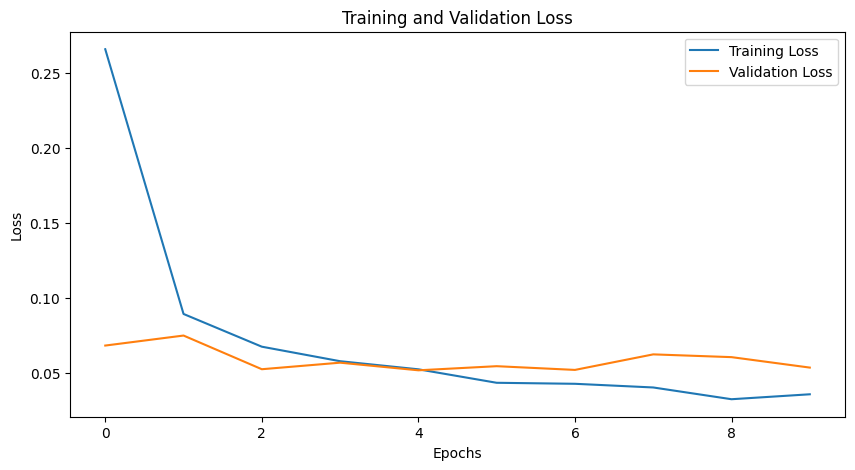

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Reload the Best LeNet Model Weights


In [ ]:
# Define the path where the best model was saved
path = Path(os.getcwd())
model_save_path = path / 'best_lenet.pth'

# Instantiate a new model with the same architecture
# Make sure you use the same model class that was trained
loaded_model = ModernLeNet5()

# Load the saved state dictionary into the new model instance
# Make sure the model is on the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /content/best_lenet.pth
Model is on device: cuda:0


## Apply our Custom Model to the Test Set

We have trained our LeNet-5 model and need to apply it to the test set to generate predictions and evaluate its performance. This step bridges the gap between PyTorch training and FiftyOne's analysis capabilities.

**Why Store Predictions as FiftyOne Classifications?**

Instead of storing raw predictions as strings or numbers, we use FiftyOne's [`Classification`](https://docs.voxel51.com/api/fiftyone.core.labels.html#fiftyone.core.labels.Classification) objects, which provide several key advantages:

**Structured Data Storage**: Classification objects encapsulate the predicted label, confidence score, and raw logits in a standardized format that FiftyOne understands.

**Evaluation Integration**: FiftyOne's evaluation framework (`evaluate_classifications()`) can compare Classification objects against ground truth labels, generating metrics like confusion matrices, per-class accuracy, and performance reports.

**Querying and Filtering**: With Classification objects, we can filter samples by confidence thresholds, find misclassifications, or identify uncertain predictions using FiftyOne's query language:

```python
# Find high-confidence predictions
high_conf = dataset.match(F("predictions.confidence") > 0.95)

# Find misclassifications  
errors = dataset.match(F("predictions.label") != F("ground_truth.label"))
```

**Visual Analysis**: The FiftyOne App can visualize Classification objects with confidence scores, making it simple to spot patterns in model behavior and identify errors.

**Model Comparison**: Storing predictions in this standardized format enables comparison between different models (like our LeNet vs. CLIP's zero-shot classification) using the same evaluation framework.

**Confidence-Based Analysis**: The embedded confidence scores allow for analysis like identifying samples where the model is uncertain, which correspond to edge cases or potential labeling errors in the dataset.

This approach transforms raw model outputs into queryable metadata that integrates with FiftyOne's computer vision workflow, enabling insights into model performance and behavior.

In [ ]:
## Apply best_model to the test set, store logits and confidence

# Create a PyTorch Dataset for the test set
torch_test_set = FiftyOneImageDataset(test_dataset,
                                      label_map=label_map, # Use the same label map as training
                                      image_transforms=image_transforms) # Use the same transforms

# Create a PyTorch DataLoader for the test set
test_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle test data
    num_workers=num_workers,
    pin_memory=True
)

print("Test DataLoader created successfully.")
print(f"Test DataLoader has {len(test_loader)} batches.")

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits
predictions = []
all_logits = []

# Run inference on the test set
print("Applying best LeNet model to the test set...")
with torch.inference_mode(): # Disable gradient calculation
    for images, _ in tqdm(test_loader):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
all_logits = np.concatenate(all_logits, axis=0)

print("Inference on test set complete.")
print(f"Shape of collected logits: {all_logits.shape}")
print(f"Number of collected predictions: {len(predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications...")

for i, sample in enumerate(test_dataset):
    # Get the predicted class index and corresponding class name
    predicted_idx = predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_classification"] = classification

    sample.save()


# Verify the stored data structure
# We should see Classification objects with label, confidence, and logits fields
print("\n=== Verification ===")
sample = test_dataset.first()
print(f"Sample prediction type: {type(sample.lenet_classification)}")
print(f"Sample prediction: {sample.lenet_classification}")
print(f"Prediction label: {sample.lenet_classification.label}")
print(f"Prediction confidence: {sample.lenet_classification.confidence}")
print(f"Prediction logits shape: {len(sample.lenet_classification.logits)}")

session.refresh()
print(f"\nFiftyOne App URL: {session.url}")



FiftyOneImageDataset initialized with 10000 samples.
Test DataLoader created successfully.
Test DataLoader has 157 batches.
Applying best LeNet model to the test set...


100%|██████████| 157/157 [00:01<00:00, 86.87it/s] 


Inference on test set complete.
Shape of collected logits: (10000, 10)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications...
Predictions and logits stored successfully as FiftyOne Classifications.

=== Verification ===
Sample prediction type: <class 'fiftyone.core.labels.Classification'>
Sample prediction: <Classification: {
    'id': '684888bbf54ab7f71ac39842',
    'tags': [],
    'label': '7 - seven',
    'confidence': 1.0,
    'logits': array([-27.59289742, -12.8867178 ,  -7.60676003, -11.13029289,
           -12.18529224, -21.21888161, -40.30902481,  16.22479248,
           -14.59798431,  -6.27745438]),
}>
Prediction label: 7 - seven
Prediction confidence: 1.0
Prediction logits shape: 10

FiftyOne App URL: https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


In [ ]:
# Create a view showing only LeNet's high-confidence predictions
high_confidence_view = test_dataset.match(
    F("lenet_prediction.confidence") > 0.9
)
print(f"\nHigh confidence predictions (>0.9): {len(high_confidence_view)} samples")

# Create a view showing only LeNet's misclassifications
misclassified_view = test_dataset.match(
    F("lenet_prediction.label") != F("ground_truth.label")
)
print(f"Misclassified samples: {len(misclassified_view)} samples")



High confidence predictions (>0.9): 0 samples
Misclassified samples: 10000 samples


## Evaluating LeNet's Classification Performance

In [ ]:
lenet_evaluation_results = test_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

session.refresh()
print(session.url)

https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


In [ ]:
lenet_evaluation_results.print_report()

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99       980
     1 - one       0.99      1.00      0.99      1135
     2 - two       0.99      0.98      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       1.00      0.99      0.99       958
   7 - seven       0.98      0.99      0.98      1028
   8 - eight       0.98      0.99      0.99       974
    9 - nine       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
# Compute quantiles of confidence
test_dataset.quantiles("lenet_classification.confidence", [0.25, 0.5, 0.75] )

[0.9999808073043823, 0.9999998807907104, 1.0]

## Evaluating Sample Hardness and Mistakennes through their Logits



In [ ]:
#Hardness is a measure computed based on model prediction output (through
#logits) that summarizes a measure of the uncertainty the model had with the
#sample. This makes hardness quantitative and can be used to detect things
#like hard samples and annotation errors
fob.compute_hardness(test_dataset,
                     label_field='lenet_classification',
                     )

Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |█████████████| 10000/10000 [20.4s elapsed, 0s remaining, 481.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [20.4s elapsed, 0s remaining, 481.8 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


In [ ]:
# Evaluate sample mistakenness (how likely the sample is mislabeled)
# Samples with high mistakenness often have conflicting model output and ground truth
fob.compute_mistakenness(test_dataset,
                        pred_field="lenet_classification",
                        label_field="ground_truth")


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |█████████████| 10000/10000 [17.9s elapsed, 0s remaining, 565.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [17.9s elapsed, 0s remaining, 565.6 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


In [ ]:
session.refresh()
print(f"\nFiftyOne App URL: {session.url}")


FiftyOne App URL: https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


## Creating Embeddings from the LeNet-5 Model

In [ ]:
## Extract Embeddings from LeNet Model Using PyTorch Hooks

def extract_lenet_embeddings(model, dataloader, device, layer_name='fc1'):
    """
    Extract embeddings from a specified layer of the LeNet model using PyTorch hooks.

    Args:
        model: Trained LeNet model
        dataloader: PyTorch DataLoader
        device: Device to run inference on
        layer_name: Name of the layer to extract embeddings from
                   Options: 'conv3', 'fc1', or 'fc2'

    Returns:
        numpy array of embeddings
    """
    # Dictionary to store the embeddings
    embeddings_dict = {}

    def hook_fn(module, input, output):
        """Hook function to capture layer outputs"""
        # Flatten the output if it's from conv layers
        if len(output.shape) > 2:
            embeddings_dict['embeddings'] = output.view(output.size(0), -1).cpu().detach()
        else:
            embeddings_dict['embeddings'] = output.cpu().detach()

    # Register the hook on the specified layer
    layer_map = {
        'conv3': model.conv3,  # Shape: (batch_size, 120, 1, 1) -> flattened to (batch_size, 120)
        'fc1': model.fc1,     # Shape: (batch_size, 84) - most common choice
        'fc2': model.fc2      # Shape: (batch_size, 10) - final logits
    }

    if layer_name not in layer_map:
        raise ValueError(f"Invalid layer_name. Choose from: {list(layer_map.keys())}")

    target_layer = layer_map[layer_name]
    hook_handle = target_layer.register_forward_hook(hook_fn)

    # Set model to evaluation mode
    model.eval()

    all_embeddings = []

    print(f"Extracting embeddings from {layer_name} layer...")

    with torch.inference_mode():
        for images, _ in tqdm(dataloader, desc="Processing batches"):
            images = images.to(device)

            # Forward pass (hook will capture the embeddings)
            _ = model(images)

            # Store the captured embeddings
            batch_embeddings = embeddings_dict['embeddings'].numpy()
            all_embeddings.append(batch_embeddings)

    # Remove the hook to clean up
    hook_handle.remove()

    # Concatenate all embeddings
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    print(f"Extracted embeddings shape: {final_embeddings.shape}")
    print(f"Embedding dimension: {final_embeddings.shape[1]}")

    return final_embeddings

In [ ]:
# Create a new DataLoader for the train_set specifically for inference, ensuring shuffle is False
# This uses the torch_train_set which is derived from train_view
train_inference_loader = torch.utils.data.DataLoader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=False,    # CRITICAL: Must be False for ordered predictions
    num_workers=num_workers,
    pin_memory=True
)

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits for the training set
train_predictions = []
train_all_logits = []

# Run inference on the training set using the NON-SHUFFLED loader
print("Applying LeNet model to the train_view (using non-shuffled loader)...")
with torch.inference_mode(): # Disable gradient calculation
    # Use the new train_inference_loader
    for images, _ in tqdm(train_inference_loader, desc="Processing train batches for inference"):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        train_all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        train_predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
train_all_logits = np.concatenate(train_all_logits, axis=0)

print("Inference on train_view complete.")
print(f"Shape of collected train logits: {train_all_logits.shape}")
print(f"Number of collected train predictions: {len(train_predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for train_view...")
for i, sample in enumerate(tqdm(train_view, desc="Storing train classifications")):
    predicted_idx = train_predictions[i]
    predicted_label = dataset_classes[predicted_idx] # Assuming dataset_classes is consistent
    sample_logits = train_all_logits[i]
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )
    sample["lenet_train_classification"] = classification
    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for train_view.")

Applying LeNet model to the train_view (using non-shuffled loader)...


Processing train batches for inference: 100%|██████████| 797/797 [00:06<00:00, 127.16it/s]


Inference on train_view complete.
Shape of collected train logits: (51000, 10)
Number of collected train predictions: 51000
Storing predictions and logits as FiftyOne Classifications for train_view...


Storing train classifications: 100%|██████████| 51000/51000 [02:02<00:00, 416.58it/s]

Predictions and logits stored successfully as FiftyOne Classifications for train_view.


In [ ]:
lenet_train_evaluation_results.print_report()

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      1.00      5006
     1 - one       1.00      0.99      1.00      5727
     2 - two       0.99      0.99      0.99      5078
   3 - three       0.99      0.99      0.99      5192
    4 - four       0.99      0.99      0.99      4931
    5 - five       0.99      0.99      0.99      4632
     6 - six       1.00      0.99      0.99      5053
   7 - seven       0.99      1.00      0.99      5369
   8 - eight       0.98      0.99      0.99      4979
    9 - nine       1.00      0.98      0.99      5033

    accuracy                           0.99     51000
   macro avg       0.99      0.99      0.99     51000
weighted avg       0.99      0.99      0.99     51000



## Creating a View of False Positives and False Negatives in the Training Data

In [ ]:
mislabeled_train_images_view = \
train_view.match(
    F("lenet_train_classification.label")!= F("ground_truth.label"))

mislabeled_train_images_view


Dataset:     mnist-train-val
Media type:  image
Num samples: 443
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:                 fiftyone.core.fields.DateTimeField
    last_modified_at:           fiftyone.core.fields.DateTimeField
    ground_truth:               fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lenet_train_classification: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lenet_embeddings:           fiftyone.core.fields.VectorField
    uniqueness:                 fiftyone.core.fields.FloatField
    representativeness:         fiftyone.core.fields.FloatField
    lenet_train_eval:      

In [ ]:
session = fo.launch_app(mislabeled_train_images_view, auto=False)
print(session.url)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


## Extract Embeddings from the Trained LeNet

In [ ]:
# Extract embeddings from the fc1 layer (84-dimensional representations)
lenet_embeddings = extract_lenet_embeddings(
    model=loaded_model,
    dataloader=train_loader,
    device=device,
    layer_name='fc1'  # 84-dimensional embeddings from fully connected layer
)

print(f"LeNet embeddings extracted: {lenet_embeddings.shape}")

Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 797/797 [00:06<00:00, 120.23it/s]

Extracted embeddings shape: (51000, 84)
Embedding dimension: 84
LeNet embeddings extracted: (51000, 84)


In [ ]:
## Store LeNet Embeddings in FiftyOne Dataset

print("Storing LeNet embeddings in FiftyOne dataset...")

# Store embeddings in each sample
for index, sample in enumerate(tqdm(train_view, desc="Storing embeddings")):
    sample["lenet_embeddings"] = lenet_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from train_view.")

# Verify storage
sample = train_view.first()
print(f"Sample LeNet embedding shape: {sample.lenet_embeddings.shape}")
print(f"Embedding type: {type(sample.lenet_embeddings)}")

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 51000/51000 [01:39<00:00, 513.45it/s]

LeNet embeddings stored successfully in samples from train_view.
Sample LeNet embedding shape: (84,)
Embedding type: <class 'numpy.ndarray'>


## Evaluating Image Representativeness and Uniqueness through their Embeddings

**Image representativeness** and **uniqueness** are metrics for understanding dataset quality and composition that work hand-in-hand with clustering analysis.

**Representativeness** measures how well a sample captures the central characteristics of its cluster, highly representative images sit near cluster centers and exemplify the common visual patterns within each group.

**Uniqueness** identifies samples that are distant from any cluster centers, often representing edge cases, rare scenarios, or potential annotation errors that clustering algorithms struggle to categorize.

These scores are normalized to [0, 1] and become particularly insightful when viewed alongside clustering results. Representative samples serve as ideal cluster exemplars for understanding what each group represents, while highly unique samples often fall between clusters or form singleton groups, indicating unusual data points that may require special handling in our machine learning pipeline.


In [ ]:
## Compute Uniqueness and Representativeness for LeNet Embeddings

print("Computing uniqueness scores based on LeNet embeddings...")
fob.compute_uniqueness(train_view, embeddings=lenet_embeddings)

print("Computing representativeness scores based on LeNet embeddings...")
fob.compute_representativeness(train_view, embeddings=lenet_embeddings)

print("Uniqueness and representativeness computation complete.")

## Create 2D Visualization of LeNet Embeddings

print("Creating 2D visualizations of LeNet embeddings...")

# PCA visualization
pca_viz_lenet = fob.compute_visualization(
    train_view,
    method="pca",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="pca_lenet_embeddings"
)

# UMAP visualization
umap_viz_lenet = fob.compute_visualization(
    train_view,
    method="umap",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="umap_lenet_embeddings"
)

print("2D visualizations created successfully.")

Computing uniqueness scores based on LeNet embeddings...
Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness scores based on LeNet embeddings...
Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 51000 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 51000 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


Uniqueness and representativeness computation complete.
Creating 2D visualizations of LeNet embeddings...
Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Tue Jun 10 20:06:29 2025 Construct fuzzy simplicial set
Tue Jun 10 20:06:29 2025 Finding Nearest Neighbors
Tue Jun 10 20:06:29 2025 Building RP forest with 16 trees


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Tue Jun 10 20:06:29 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Tue Jun 10 20:06:31 2025 Finished Nearest Neighbor Search
Tue Jun 10 20:06:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jun 10 20:06:49 2025 Finished embedding
2D visualizations created successfully.


## Exploring Uniqueness and Representativeness with Dataset Aggregations

We can use FiftyOne's aggregation methods to explore the distribution of uniqueness and representativeness values across our dataset.

This analysis helps us identify meaningful thresholds for categorizing our samples:


In [ ]:
## Analyze Uniqueness and Representativeness Distributions

# Get quantiles for uniqueness based on LeNet embeddings
uniqueness_quantiles = train_view.aggregate(fo.Quantiles("uniqueness",
 [0.05, 0.25, 0.5, 0.75, 0.95]))
print(f"Uniqueness quantiles: {uniqueness_quantiles}")

# Get quantiles for representativeness based on LeNet embeddings
repr_quantiles = train_view.aggregate(fo.Quantiles("representativeness",
 [0.05, 0.25, 0.5, 0.75, 0.95]))
print(f"Representativeness quantiles: {repr_quantiles}")



Uniqueness quantiles: [0.06211367946843244, 0.10093743809400879, 0.1407793788830863, 0.2035426564139454, 0.3749353966498615]
Representativeness quantiles: [0.15673600137233734, 0.24036845564842224, 0.3184733986854553, 0.41547295451164246, 0.6019662022590637]


We can use filtered Views of the dataset to get the most unique values and launch the app from them.

In [ ]:
## Create Views for Most Unique and Most Representative Samples

# Most unique samples (top 5% - these are often edge cases or outliers)
most_unique = train_view.match(F("uniqueness") > uniqueness_quantiles[4])  # > 95th percentile
print(f"Most unique samples: {len(most_unique)} samples")

# Most representative samples (top 25% - these exemplify their clusters well)
most_representative = train_view.match(F("representativeness") > repr_quantiles[3])  # > 75th percentile
print(f"Most representative samples: {len(most_representative)} samples")


Most unique samples: 2550 samples
Most representative samples: 12750 samples


In [ ]:
## Launch FiftyOne App to Visualize Results

session = fo.launch_app(most_unique, auto=False)
print(f"FiftyOne App URL: {session.url}")



Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


FiftyOne App URL: https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


## Augmenting the Misclassified Training Samples and Retrain



### Effective Augmentations for MNIST


### Geometric Transformations:

* Small rotations (±10-15 degrees): Handwritten digits naturally vary in orientation
* Small translations (±2-3 pixels): Accounts for centering variations in digit positioning
* Slight scaling (0.9-1.1x): Handles size variations in handwriting
* Moderate elastic deformations are  useful for MNIST because they simulate the natural variations in handwriting style - imagine stretching and compressing parts of a digit as different people might write them.
### Why These Work
The principle behind effective augmentation is creating realistic variations that preserve the digit's identity while exposing the model to plausible distortions. MNIST digits are centered and normalized, so augmentations should introduce controlled variability without making digits unrecognizable.
### Augmentations to Avoid
* Heavy distortions like large rotations (>20°), extreme scaling, or aggressive elastic deformation can make digits ambiguous - a rotated "6" might look like a "9", or a heavily stretched "1" might resemble a "7".

* Color-based augmentations (brightness, contrast) have limited benefit since MNIST is grayscale and already normalized.

In [ ]:
session.view = mislabeled_train_images_view
print(session.url)

https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true


## Final Evaluation

Number of misclassified training samples: 443
AugmentedMNISTDataset: 443 base samples
With augmentation factor 3: 1772 total samples
Original misclassified samples: 443
Total augmented dataset size: 1772
Original training set size: 51000
Augmented misclassified samples: 1772
Combined training set size: 52772
Combined DataLoader has 825 batches.

Visualizing augmentation examples...


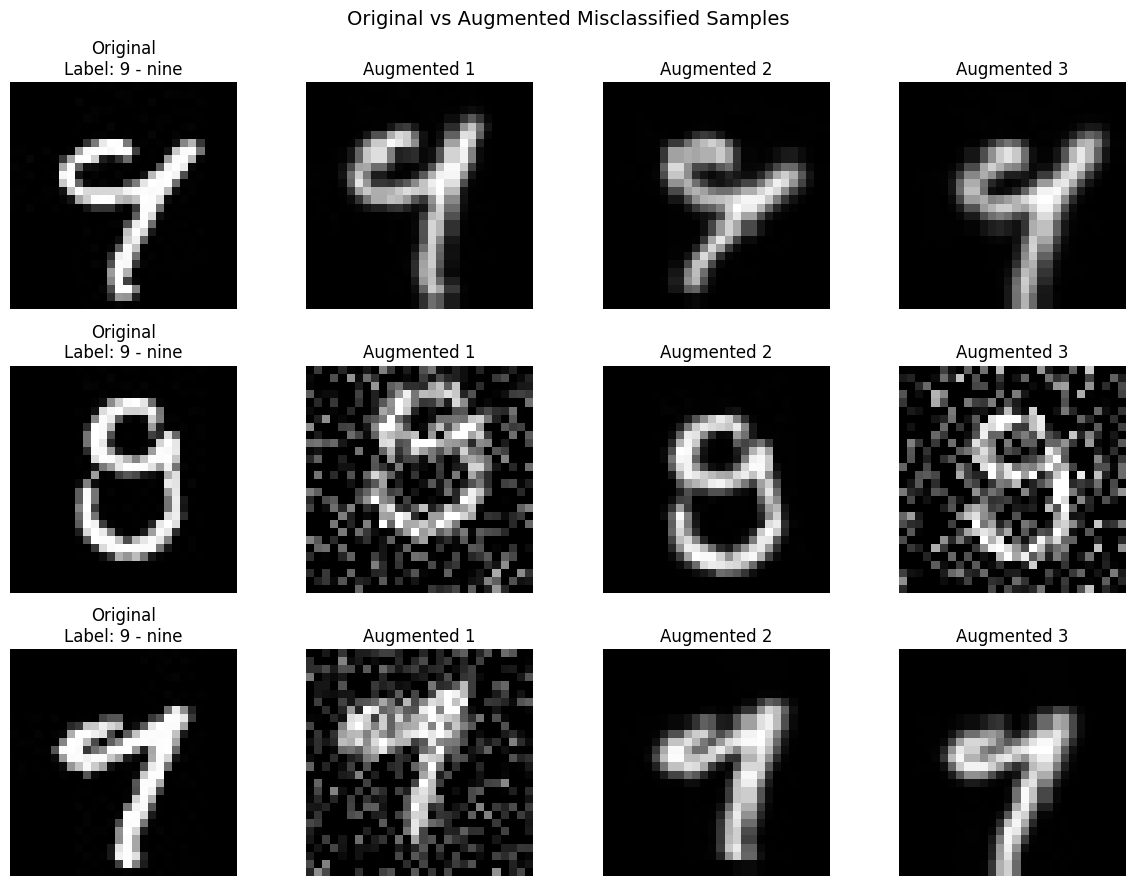

Loaded best model from /content/best_lenet.pth for retraining
Optimizer configured for retraining with lower learning rate

Starting retraining with augmented data...

--- Retrain Epoch 1/3 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 80.42it/s] 


Epoch 1: Train Loss: 0.0817, Val Loss: 0.0361
✓ Saved improved retrained model

--- Retrain Epoch 2/3 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 86.13it/s] 


Epoch 2: Train Loss: 0.0610, Val Loss: 0.0387

--- Retrain Epoch 3/3 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 81.81it/s] 


Epoch 3: Train Loss: 0.0505, Val Loss: 0.0404

Retraining complete! Best model saved to /content/retrained_lenet.pth


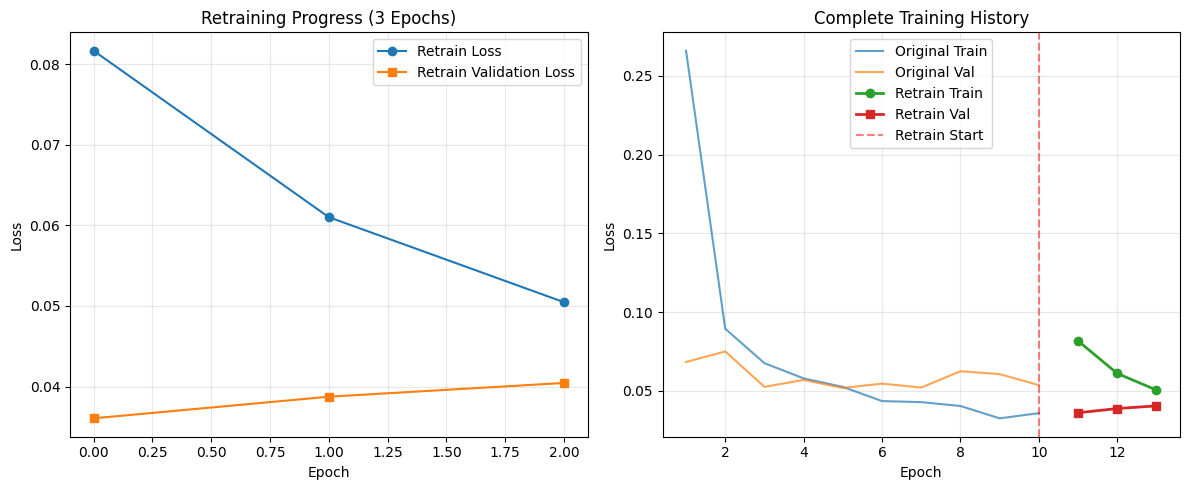


Applying retrained model to test set...


Evaluating retrained model: 100%|██████████| 157/157 [00:01<00:00, 85.50it/s] 


Retrained model evaluation complete.
Predictions shape: 10000
Logits shape: (10000, 10)
Storing retrained model predictions in FiftyOne...


Storing retrained predictions: 100%|██████████| 10000/10000 [00:34<00:00, 293.59it/s]


Retrained model predictions stored successfully!

Evaluating retrained model performance...

RETRAINED MODEL EVALUATION RESULTS
              precision    recall  f1-score   support

    0 - zero       0.99      0.99      0.99       980
     1 - one       0.99      1.00      0.99      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.99      0.98      0.99      1028
   8 - eight       0.99      0.99      0.99       974
    9 - nine       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


PERFORMANCE COMPARISON
Metric               Original     Retrained    Improvement 
-----------------------------

INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


FiftyOne App URL: https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true

AUGMENTATION AND RETRAINING SUMMARY
✓ Identified 443 misclassified training samples
✓ Applied MNIST-appropriate augmentations (rotation, translation, elastic deform)
✓ Created 1772 augmented training samples
✓ Retrained model for 3 epochs with combined dataset
✓ Evaluated performance on test set
✓ Net improvement: 20 correctly classified samples

Key Insights:
- Data augmentation helps with misclassified samples
- Small rotations and elastic deformations are effective for handwritten digits
- Fine-tuning with augmented data can improve model robustness
- FiftyOne enables easy tracking of prediction changes across model versions


In [ ]:
import albumentations as A
import cv2
from torch.utils.data import Dataset, ConcatDataset

## Data Augmentation for Misclassified Training Samples

print(f"Number of misclassified training samples: {len(mislabeled_train_images_view)}")

# Define effective augmentations for MNIST handwritten digits
mnist_augmentations = A.Compose([
    # Small rotations to simulate natural handwriting variation
    A.Rotate(limit=15, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=0),

    # Small translations to account for centering variations
    A.ShiftScaleRotate(
        shift_limit=0.1,      # ±10% translation
        scale_limit=0.1,      # ±10% scaling
        rotate_limit=10,      # ±10° additional rotation
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        p=0.8
    ),

    # Elastic deformations to simulate handwriting style variations
    A.ElasticTransform(
        alpha=20,             # Strength of distortion
        sigma=5,              # Smoothness of distortion
        alpha_affine=0,       # No affine transformation
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        p=0.6
    ),

    # Grid distortion for additional handwriting-like variations
    A.GridDistortion(
        num_steps=3,          # Number of grid cells
        distort_limit=0.1,    # Small distortions
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        p=0.5
    ),

    # Slight Gaussian noise to increase robustness
    A.GaussNoise(
        var_limit=(0.0, 0.005),  # Very small noise
        p=0.3
    )
])

class AugmentedMNISTDataset(Dataset):
    """
    Dataset that applies augmentations to misclassified MNIST samples.
    Each sample can be augmented multiple times to create more training data.
    """

    def __init__(self, fiftyone_view, label_map, base_transforms,
                 augmentations=None, augment_factor=3):
        """
        Args:
            fiftyone_view: FiftyOne view of misclassified samples
            label_map: Mapping from string labels to indices
            base_transforms: Base PyTorch transforms (normalization, etc.)
            augmentations: Albumentations transform pipeline
            augment_factor: How many augmented versions to create per sample
        """
        self.image_paths = fiftyone_view.values("filepath")
        self.str_labels = fiftyone_view.values("ground_truth.label")
        self.label_map = label_map
        self.base_transforms = base_transforms
        self.augmentations = augmentations
        self.augment_factor = augment_factor

        print(f"AugmentedMNISTDataset: {len(self.image_paths)} base samples")
        print(f"With augmentation factor {augment_factor}: {len(self)} total samples")

    def __len__(self):
        return len(self.image_paths) * (self.augment_factor + 1)  # +1 for original

    def __getitem__(self, idx):
        # Determine which base sample and whether to augment
        base_idx = idx // (self.augment_factor + 1)
        aug_idx = idx % (self.augment_factor + 1)

        # Load image
        image_path = self.image_paths[base_idx]
        image = Image.open(image_path).convert('L')

        # Convert to numpy for albumentations
        image_np = np.array(image, dtype=np.uint8)

        # Apply augmentation if not the first version (original)
        if aug_idx > 0 and self.augmentations is not None:
            augmented = self.augmentations(image=image_np)
            image_np = augmented['image']

        # Convert back to PIL for PyTorch transforms
        image = Image.fromarray(image_np, mode='L')

        # Apply base transforms (normalization, tensor conversion)
        if self.base_transforms:
            image = self.base_transforms(image)

        # Get label
        label_str = self.str_labels[base_idx]
        label_idx = self.label_map.get(label_str, -1)

        return image, torch.tensor(label_idx, dtype=torch.long)

# Create augmented dataset for misclassified samples
augmented_dataset = AugmentedMNISTDataset(
    mislabeled_train_images_view,
    label_map=label_map,
    base_transforms=image_transforms,
    augmentations=mnist_augmentations,
    augment_factor=3  # Create 3 augmented versions per misclassified sample
)

print(f"Original misclassified samples: {len(mislabeled_train_images_view)}")
print(f"Total augmented dataset size: {len(augmented_dataset)}")

## Create Combined Training Dataset

# Combine original training data with augmented misclassified samples
combined_train_dataset = ConcatDataset([torch_train_set, augmented_dataset])

print(f"Original training set size: {len(torch_train_set)}")
print(f"Augmented misclassified samples: {len(augmented_dataset)}")
print(f"Combined training set size: {len(combined_train_dataset)}")

# Create new DataLoader for combined dataset
combined_train_loader = torch.utils.data.DataLoader(
    combined_train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the combined dataset
    num_workers=num_workers,
    pin_memory=True
)

print(f"Combined DataLoader has {len(combined_train_loader)} batches.")

## Visualize Sample Augmentations

print("\nVisualizing augmentation examples...")

# Take a few samples from misclassified data and show augmentations
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('Original vs Augmented Misclassified Samples', fontsize=14)

sample_paths = mislabeled_train_images_view.values("filepath")[:3]
sample_labels = mislabeled_train_images_view.values("ground_truth.label")[:3]

for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
    # Load original image
    original = Image.open(path).convert('L')
    original_np = np.array(original)

    # Show original
    axes[i, 0].imshow(original_np, cmap='gray')
    axes[i, 0].set_title(f'Original\nLabel: {label}')
    axes[i, 0].axis('off')

    # Show 3 augmented versions
    for j in range(3):
        augmented = mnist_augmentations(image=original_np)['image']
        axes[i, j+1].imshow(augmented, cmap='gray')
        axes[i, j+1].set_title(f'Augmented {j+1}')
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

## Load Best Model for Retraining

# Load the previously saved best model
best_model_path = Path(os.getcwd()) / 'best_lenet.pth'
retrain_model = ModernLeNet5()
retrain_model.load_state_dict(torch.load(best_model_path, map_location=device))
retrain_model = retrain_model.to(device)

print(f"Loaded best model from {best_model_path} for retraining")

# Use a lower learning rate for fine-tuning
retrain_optimizer = Adam(retrain_model.parameters(),
                        lr=0.001,  # Lower learning rate for fine-tuning
                        betas=(0.9, 0.999),
                        eps=1e-08,
                        weight_decay=1e-4)  # Small weight decay for regularization

print("Optimizer configured for retraining with lower learning rate")




Starting retraining with augmented data...

--- Retrain Epoch 1/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 74.81it/s]


Epoch 1: Train Loss: 0.0498, Val Loss: 0.0444
✓ Saved improved retrained model

--- Retrain Epoch 2/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 90.40it/s] 


Epoch 2: Train Loss: 0.0452, Val Loss: 0.0495

--- Retrain Epoch 3/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 86.83it/s] 


Epoch 3: Train Loss: 0.0432, Val Loss: 0.0362
✓ Saved improved retrained model

--- Retrain Epoch 4/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 74.17it/s] 


Epoch 4: Train Loss: 0.0405, Val Loss: 0.0427

--- Retrain Epoch 5/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 79.71it/s] 


Epoch 5: Train Loss: 0.0398, Val Loss: 0.0389

--- Retrain Epoch 6/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 86.43it/s] 


Epoch 6: Train Loss: 0.0361, Val Loss: 0.0441

--- Retrain Epoch 7/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 81.21it/s] 


Epoch 7: Train Loss: 0.0376, Val Loss: 0.0440

--- Retrain Epoch 8/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 83.08it/s] 


Epoch 8: Train Loss: 0.0359, Val Loss: 0.0411

--- Retrain Epoch 9/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 80.84it/s] 


Epoch 9: Train Loss: 0.0328, Val Loss: 0.0462

--- Retrain Epoch 10/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 77.45it/s] 


Epoch 10: Train Loss: 0.0346, Val Loss: 0.0411

--- Retrain Epoch 11/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 83.24it/s] 


Epoch 11: Train Loss: 0.0336, Val Loss: 0.0407

--- Retrain Epoch 12/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 79.03it/s] 


Epoch 12: Train Loss: 0.0333, Val Loss: 0.0444

--- Retrain Epoch 13/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 79.83it/s] 


Epoch 13: Train Loss: 0.0339, Val Loss: 0.0455

--- Retrain Epoch 14/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 87.10it/s] 


Epoch 14: Train Loss: 0.0312, Val Loss: 0.0468

--- Retrain Epoch 15/15 ---


Validation: 100%|██████████| 141/141 [00:01<00:00, 81.99it/s] 


Epoch 15: Train Loss: 0.0327, Val Loss: 0.0501

Retraining complete! Best model saved to /content/retrained_lenet.pth


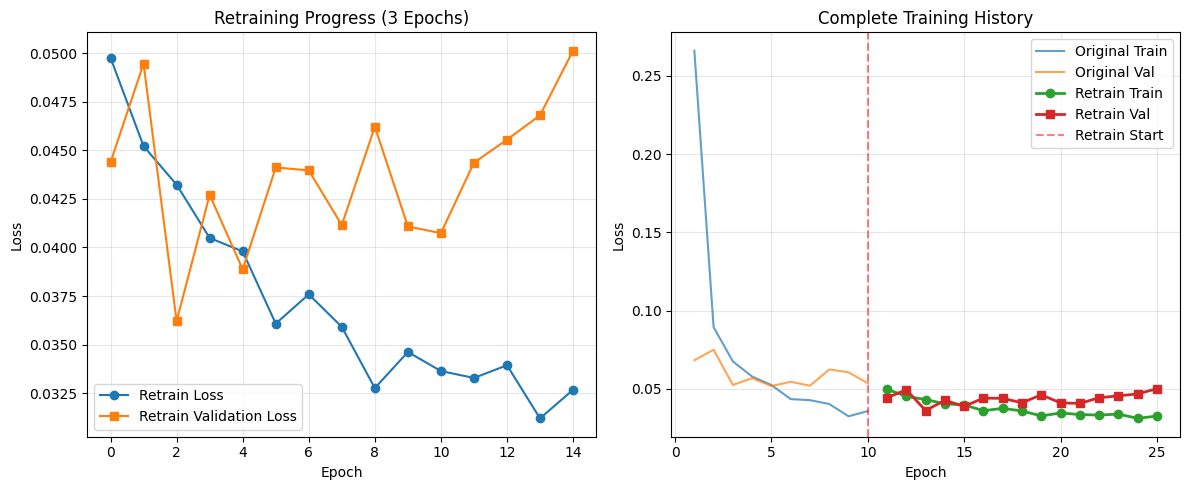


Applying retrained model to test set...


Evaluating retrained model: 100%|██████████| 157/157 [00:01<00:00, 91.07it/s] 


Retrained model evaluation complete.
Predictions shape: 10000
Logits shape: (10000, 10)
Storing retrained model predictions in FiftyOne...


Storing retrained predictions: 100%|██████████| 10000/10000 [00:39<00:00, 250.86it/s]


Retrained model predictions stored successfully!

Evaluating retrained model performance...

RETRAINED MODEL EVALUATION RESULTS
              precision    recall  f1-score   support

    0 - zero       1.00      0.99      1.00       980
     1 - one       0.99      1.00      0.99      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       0.99      0.99      0.99       974
    9 - nine       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


PERFORMANCE COMPARISON
Metric               Original     Retrained    Improvement 
-----------------------------

INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


FiftyOne App URL: https://5151-gpu-t4-hm-7il4pgla9j29-c.us-east1-1.prod.colab.dev?polling=true

AUGMENTATION AND RETRAINING SUMMARY
✓ Identified 443 misclassified training samples
✓ Applied MNIST-appropriate augmentations (rotation, translation, elastic deform)
✓ Created 1772 augmented training samples
✓ Retrained model for 15 epochs with combined dataset
✓ Evaluated performance on test set
✓ Net improvement: 36 correctly classified samples

Key Insights:
- Data augmentation helps with misclassified samples
- Small rotations and elastic deformations are effective for handwritten digits
- Fine-tuning with augmented data can improve model robustness
- FiftyOne enables easy tracking of prediction changes across model versions


In [ ]:
## Retrain for 15 Epochs

print("\nStarting retraining with augmented data...")

retrain_epochs = 15
retrain_losses = []
retrain_val_losses = []

# Track the best validation loss during retraining
best_retrain_val_loss = float('inf')
retrain_model_save_path = Path(os.getcwd()) / 'retrained_lenet.pth'

for epoch in range(retrain_epochs):
    print(f"\n--- Retrain Epoch {epoch+1}/{retrain_epochs} ---")

    # Training phase
    retrain_model.train()
    batch_losses = []

    for images, labels in tqdm(combined_train_loader, desc="Retraining"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = retrain_model(images)
        loss_value = ce_loss(logits, labels)

        # Backward pass
        retrain_optimizer.zero_grad()
        loss_value.backward()
        retrain_optimizer.step()

        batch_losses.append(loss_value.item())

    train_loss = np.mean(batch_losses)
    retrain_losses.append(train_loss)

    # Validation phase
    retrain_model.eval()
    val_batch_losses = []

    with torch.inference_mode():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)

            logits = retrain_model(images)
            loss_value = ce_loss(logits, labels)
            val_batch_losses.append(loss_value.item())

    val_loss = np.mean(val_batch_losses)
    retrain_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save best model during retraining
    if val_loss < best_retrain_val_loss:
        best_retrain_val_loss = val_loss
        torch.save(retrain_model.state_dict(), retrain_model_save_path)
        print("✓ Saved improved retrained model")

print(f"\nRetraining complete! Best model saved to {retrain_model_save_path}")

## Plot Training Progress

plt.figure(figsize=(12, 5))

# Plot retraining losses
plt.subplot(1, 2, 1)
plt.plot(retrain_losses, label='Retrain Loss', marker='o')
plt.plot(retrain_val_losses, label='Retrain Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Retraining Progress (3 Epochs)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot comparison with original training (if we have the data)
plt.subplot(1, 2, 2)
if 'train_losses' in locals() and 'val_losses' in locals():
    epochs_orig = range(1, len(train_losses) + 1)
    epochs_retrain = range(len(train_losses) + 1, len(train_losses) + 1 + len(retrain_losses))

    plt.plot(epochs_orig, train_losses, label='Original Train', alpha=0.7)
    plt.plot(epochs_orig, val_losses, label='Original Val', alpha=0.7)
    plt.plot(epochs_retrain, retrain_losses, label='Retrain Train', marker='o', linewidth=2)
    plt.plot(epochs_retrain, retrain_val_losses, label='Retrain Val', marker='s', linewidth=2)

    plt.axvline(x=len(train_losses), color='red', linestyle='--', alpha=0.5, label='Retrain Start')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Complete Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Apply Retrained Model to Test Set

print("\nApplying retrained model to test set...")

# Load the best retrained model
final_model = ModernLeNet5()
final_model.load_state_dict(torch.load(retrain_model_save_path, map_location=device))
final_model = final_model.to(device)
final_model.eval()

# Apply retrained model to test set
retrained_predictions = []
retrained_logits = []

with torch.inference_mode():
    for images, _ in tqdm(test_loader, desc="Evaluating retrained model"):
        images = images.to(device)

        logits = final_model(images)
        retrained_logits.append(logits.cpu().numpy())

        _, predicted = torch.max(logits.data, 1)
        retrained_predictions.extend(predicted.cpu().numpy())

# Concatenate all results
retrained_logits = np.concatenate(retrained_logits, axis=0)

print(f"Retrained model evaluation complete.")
print(f"Predictions shape: {len(retrained_predictions)}")
print(f"Logits shape: {retrained_logits.shape}")

## Store Retrained Model Predictions in FiftyOne

print("Storing retrained model predictions in FiftyOne...")

for i, sample in enumerate(tqdm(test_dataset, desc="Storing retrained predictions")):
    predicted_idx = retrained_predictions[i]
    predicted_label = dataset_classes[predicted_idx]
    sample_logits = retrained_logits[i]

    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )

    sample["retrained_lenet_classification"] = classification
    sample.save()

print("Retrained model predictions stored successfully!")

## Evaluate Retrained Model Performance

print("\nEvaluating retrained model performance...")

# Evaluate retrained model
retrained_evaluation_results = test_dataset.evaluate_classifications(
    "retrained_lenet_classification",
    gt_field="ground_truth",
    eval_key="retrained_lenet_eval"
)

print("\n" + "="*60)
print("RETRAINED MODEL EVALUATION RESULTS")
print("="*60)
retrained_evaluation_results.print_report()

## Compare Original vs Retrained Performance

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Get metrics for both models
original_metrics = lenet_evaluation_results.metrics()
retrained_metrics = retrained_evaluation_results.metrics()

print(f"{'Metric':<20} {'Original':<12} {'Retrained':<12} {'Improvement':<12}")
print("-" * 56)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics_to_compare:
    if metric in original_metrics and metric in retrained_metrics:
        orig_val = original_metrics[metric]
        retrain_val = retrained_metrics[metric]
        improvement = retrain_val - orig_val

        print(f"{metric:<20} {orig_val:<12.4f} {retrain_val:<12.4f} {improvement:+.4f}")

## Analysis of Misclassified Samples After Retraining

# Find samples that were misclassified before but correct now
originally_wrong = test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)

now_correct = originally_wrong.match(
    F("retrained_lenet_classification.label") == F("ground_truth.label")
)

print(f"\nSamples fixed by retraining: {len(now_correct)}")

# Find samples that were correct before but wrong now
originally_correct = test_dataset.match(
    F("lenet_classification.label") == F("ground_truth.label")
)

now_wrong = originally_correct.match(
    F("retrained_lenet_classification.label") != F("ground_truth.label")
)

print(f"Samples broken by retraining: {len(now_wrong)}")

# Net improvement
net_improvement = len(now_correct) - len(now_wrong)
print(f"Net improvement in correct predictions: {net_improvement}")

## Launch FiftyOne App with Results

print("\nLaunching FiftyOne App to explore results...")

# Create a view showing the comparison
comparison_view = test_dataset.select_fields([
    "ground_truth",
    "lenet_classification",
    "retrained_lenet_classification"
])

session = fo.launch_app(comparison_view, auto=False)
print(f"FiftyOne App URL: {session.url}")

print("\n" + "="*60)
print("AUGMENTATION AND RETRAINING SUMMARY")
print("="*60)
print(f"✓ Identified {len(mislabeled_train_images_view)} misclassified training samples")
print(f"✓ Applied MNIST-appropriate augmentations (rotation, translation, elastic deform)")
print(f"✓ Created {len(augmented_dataset)} augmented training samples")
print(f"✓ Retrained model for {retrain_epochs} epochs with combined dataset")
print(f"✓ Evaluated performance on test set")
print(f"✓ Net improvement: {net_improvement} correctly classified samples")


## Key Insights
Data augmentation helps with misclassified samples: By specifically targeting the samples that our model struggled with during initial training, we can create additional training examples that help the model learn to handle these edge cases more effectively.

Small rotations and elastic deformations are effective for handwritten digits: These transformations mimic natural variations in human handwriting without making digits ambiguous. The key is finding the right balance - enough variation to improve robustness, but not so much that a "6" looks like a "9".

Fine-tuning with augmented data can improve model robustness: Rather than training from scratch, fine-tuning the already-trained model with augmented versions of problematic samples allows us to specifically address weaknesses while preserving the knowledge already learned.

FiftyOne enables easy tracking of prediction changes across model versions: By storing predictions from both the original and retrained models in the same dataset, we can directly compare performance and identify which specific samples improved or degraded, enabling targeted analysis and further improvements.



## Key Takeaways

This tutorial demonstrates several fundamental principles:

- **Zero-shot vs. Supervised Learning**: Modern pre-trained models can often achieve competitive performance without task-specific training, but custom models allow for domain-specific optimization
- **Embeddings as Universal Representations**: High-dimensional vectors capture semantic similarity and enable powerful analysis and visualization techniques  
- **Visual Debugging**: FiftyOne's interactive capabilities make it easy to understand model behavior and identify improvement opportunities
- **Data Quality Matters**: Systematic analysis of your dataset often leads to more significant performance gains than model architecture changes





# Image Classification Getting Started Series Summary

This comprehensive series walks you through the core components of working with
classification data in FiftyOne: from loading and visualizing datasets, to creating embeddings, evaluating models, and finding systematic errors.

## Summary of Steps

### Step 1: Understanding the MNIST Dataset

Explore the MNIST dataset structure and load it into FiftyOne. Learn about the 60,000 training images and 10,000 test images of handwritten digits, and understand why this dataset remains fundamental for classification research.

### Step 2: Creating and Visualizing Image Embeddings

Learn how neural networks represent images as high-dimensional vectors. Generate embeddings with CLIP and visualize them using dimensionality reduction techniques like PCA and UMAP to understand image similarity and clustering.

### Step 3: Zero-shot Classification with CLIP

Discover how modern vision-language models can classify images without explicit training on your dataset. Use pre-computed embeddings to perform efficient zero-shot classification with meaningful text prompts.

### Step 4: Evaluating Dataset Quality through Embeddings

Assess your dataset's composition by analyzing embedding distributions. Learn to identify representative samples, outliers, and potential data quality issues using FiftyOne's analysis capabilities.

### Step 5: Traditional Supervised Classification

Build a custom Convolutional Neural Network (LeNet-5) from scratch in PyTorch. Understand the fundamentals of supervised learning including convolutional layers, training loops, and optimization.

### Step 6: Bridging FiftyOne and PyTorch

Master the integration between FiftyOne's dataset management and PyTorch's training capabilities. Convert datasets to DataLoaders while maintaining metadata and handling preprocessing efficiently.

### Step 7: Model Comparison and Benchmarking

Compare your custom CNN against CLIP's zero-shot classification using FiftyOne's evaluation framework. Learn comprehensive evaluation metrics and statistical significance testing.

### Step 8: Analyzing Model Predictions

Interpret model behavior by examining prediction confidence and identifying hard samples. Use logit analysis to find systematic misclassification patterns and debug model failures.

### Step 9: Data Augmentation Strategies

Improve model performance through principled data augmentation. Learn which geometric transformations and elastic deformations help MNIST classification while avoiding destructive augmentations.

### Step 10: Advanced Error Analysis

Create targeted views of model failures using FiftyOne's visualization capabilities. Identify false positives, false negatives, and the most problematic samples for systematic model improvement.

---

This series is part of the **Getting Started with FiftyOne** initiative. For
more tutorials, head to [FiftyOne Documentation](https://docs.voxel51.com/).



## Suggested Exercises

1. **Sample Quality Analysis**: Notice that we computed the uniqueness, representativeness, and hardness of the samples on the training set. Can you create filtered views of other batches of retraining data based on them? Try selecting the most unique samples or those with highest hardness scores for additional augmentation.

2. **Active Learning**: Use the uniqueness and hardness metrics to implement an active learning pipeline that selects the most informative samples for manual annotation or additional augmentation.

3. **Dataset Exploration**: Apply these techniques to other classification datasets like [CIFAR-10](https://docs.voxel51.com/dataset_zoo/datasets.html#dataset-zoo-cifar10) or [Fashion-MNIST](https://docs.voxel51.com/dataset_zoo/datasets.html#dataset-zoo-fashion-mnist)

4. **Architecture Comparison**: Implement and compare different CNN architectures (e.g. [Network in Network](https://arxiv.org/pdf/1312.4400), [ResNet](https://arxiv.org/pdf/1512.03385)) on MNIST

5. **Transfer Learning**: Use pre-trained ImageNet models and fine-tune them for digit classification

6. **Custom Augmentations**: Design and test novel augmentation strategies specific to handwritten digits, try augmenting the dataset [adding colors to the digits](https://paperswithcode.com/dataset/colored-mnist) and see how this change impacts the model's performance.

7. **CLIP Model Variants and Prompting**: Experiment with different CLIP model variants available in FiftyOne's Model Zoo and compare their zero-shot performance on MNIST. Test how different text prompts affect accuracy across model sizes.


## Resources and Further Reading

- [FiftyOne Documentation](https://docs.voxel51.com/)
- [FiftyOne's Filtering Cheatsheet](https://docs.voxel51.com/cheat_sheets/filtering_cheat_sheet.html)
- [FiftyOne Model Zoo](https://docs.voxel51.com/user_guide/model_zoo/index.html)
- [FiftyOne Dataset Zoo](https://docs.voxel51.com/user_guide/dataset_zoo/index.html)
- [PyTorch Classification Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [CLIP Paper: Learning Transferable Visual Representations](https://arxiv.org/abs/2103.00020)

## Next Steps

Now that you've completed the Image Classification Getting Started series, here are
some suggested next steps to deepen your journey with FiftyOne:

-   **Explore Object Detection**  
    Learn how to work with bounding boxes, evaluate detection models, and find annotation mistakes in object detection datasets.

-   **Try Multi-label Classification**  
    Extend these concepts to scenarios where images can belong to multiple classes simultaneously, common in real-world applications.

-   **Experiment with FiftyOne Plugins**  
    Enhance your workflow with powerful plugins for advanced augmentations, active learning tools, and integrations with annotation platforms.

-   **Connect with the Community**  
    Share your findings, ask questions, or browse community projects on the
    [FiftyOne Discord](https://community.voxel51.com) or
    [GitHub Discussions](https://github.com/voxel51/fiftyone/discussions).

-   **Apply to Your Own Datasets**  
    Adapt these workflows to your real-world classification projects. Whether
    it's medical imaging, satellite analysis, or manufacturing quality control — FiftyOne supports diverse domains.

-   **Dive into Advanced Topics**  
    Explore segmentation, video analysis, and 3D data in the
    [official documentation](https://docs.voxel51.com/).

